# **Import Datasets JPX Tokyo Stocks Market From Kaggle**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"hendricoyehezky","key":"000aadf5b9b340dd8e04c46d7942d8f4"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c jpx-tokyo-stock-exchange-prediction

jpx-tokyo-stock-exchange-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/jpx-tokyo-stock-exchange-prediction.zip

Archive:  /content/jpx-tokyo-stock-exchange-prediction.zip
replace data_specifications/options_spec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace data_specifications/options_spec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data_specifications/options_spec.csv  
  inflating: data_specifications/stock_fin_spec.csv  
  inflating: data_specifications/stock_list_spec.csv  
  inflating: data_specifications/stock_price_spec.csv  
  inflating: data_specifications/trades_spec.csv  
  inflating: example_test_files/financials.csv  
  inflating: example_test_files/options.csv  
  inflating: example_test_files/sample_submission.csv  
  inflating: example_test_files/secondary_stock_prices.csv  
  inflating: example_test_files/stock_prices.csv  
  inflating: example_test_files/trades.csv  
  inflating: jpx_tokyo_market_prediction/__init__.py  
  inflating: jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: stock_lis

# **Libraries dan Moduls**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import altair as alt
import itertools
import time
import copy

import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.figure_factory as ff
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Datasets**

In [ ]:
stock_list_df = pd.read_csv('../content/stock_list.csv')
financials_df = pd.read_csv('../content/train_files/financials.csv')
options_df = pd.read_csv('../content/train_files/options.csv')
sec_stock_prices_df = pd.read_csv('../content/train_files/secondary_stock_prices.csv')
stock_prices_df = pd.read_csv('../content/train_files/stock_prices.csv')
trades_df = pd.read_csv('../content/train_files/trades.csv')

In [ ]:
stock_list_df.head()

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False
3,1308,20211230,Nikko Exchange Traded Index Fund TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2053.0,3.736943e+09,7.671945e+12,False
4,1309,20211230,NEXT FUNDS ChinaAMC SSE50 Index Exchange Trade...,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,44280.0,7.263200e+04,3.216145e+09,False


In [ ]:
financials_df.head()

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,...,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0
2,2.016123e+13,20170104_4575,2017-01-04,4575.0,2017-01-04,12:00:00,1.483499e+09,ForecastRevision,2016-12-31,2Q,...,-93.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.017010e+13,20170105_2659,2017-01-05,2659.0,2017-01-05,15:00:00,1.483596e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,285.05,NaN,False,True,False,False,False,31981654.0,18257,31963405.0
4,2.017011e+13,20170105_3050,2017-01-05,3050.0,2017-01-05,15:30:00,1.483598e+09,ForecastRevision,2017-02-28,FY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
options_df.head()

,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,...,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0,0.0
2,20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,680.0,677.3710,17.4736,15.8644,0.0091,0.0,0.0
3,20170104_132010318,2017-01-04,132010318,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,795.0,791.0383,17.4736,15.2288,0.0091,0.0,0.0
4,20170104_132010518,2017-01-04,132010518,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,910.0,909.9947,17.4736,14.5932,0.0091,0.0,0.0


In [ ]:
sec_stock_prices_df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1305,2017-01-04,1305,1594.0,1618.0,1594.0,1615.0,538190,1.0,NaN,False,-0.001855
1,20170104_1306,2017-01-04,1306,1575.0,1595.0,1573.0,1593.0,2494980,1.0,NaN,False,-0.000627
2,20170104_1308,2017-01-04,1308,1557.0,1580.0,1557.0,1578.0,526100,1.0,NaN,False,-0.001900
3,20170104_1309,2017-01-04,1309,28810.0,29000.0,28520.0,28780.0,403,1.0,NaN,False,0.005237
4,20170104_1311,2017-01-04,1311,717.0,735.0,717.0,734.0,5470,1.0,NaN,False,0.001359


In [ ]:
stock_prices_df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [ ]:
trades_df.head()

,Date,StartDate,EndDate,Section,TotalSales,TotalPurchases,TotalTotal,TotalBalance,ProprietarySales,ProprietaryPurchases,...,CityBKsRegionalBKsEtcTotal,CityBKsRegionalBKsEtcBalance,TrustBanksSales,TrustBanksPurchases,TrustBanksTotal,TrustBanksBalance,OtherFinancialInstitutionsSales,OtherFinancialInstitutionsPurchases,OtherFinancialInstitutionsTotal,OtherFinancialInstitutionsBalance
0,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Jumlah Observasi pada ke-6 dataframes

In [ ]:
obs_stock_list = stock_list_df.shape[0]
print(f"Jumlah Observasi pada dataframe (stock_list): {obs_stock_list}")

Jumlah Observasi pada dataframe (stock_list): 4417


In [ ]:
obs_financials = financials_df.shape[0]
print(f"Jumlah Observasi pada dataframe (financials): {obs_financials}")

Jumlah Observasi pada dataframe (financials): 92956


In [ ]:
obs_options = options_df.shape[0]
print(f"Jumlah Observasi pada dataframe (options): {obs_options}")

Jumlah Observasi pada dataframe (options): 3567694


In [ ]:
obs_ssp = sec_stock_prices_df.shape[0]
print(f"Jumlah Observasi pada dataframe (ssp): {obs_ssp}")

Jumlah Observasi pada dataframe (ssp): 2384575


In [ ]:
obs_stock_prices = stock_prices_df.shape[0]
print(f"Jumlah Observasi pada dataframe (stock_prices): {obs_stock_prices}")

Jumlah Observasi pada dataframe (stock_prices): 2332531


In [ ]:
obs_trades = trades_df.shape[0]
print(f"Jumlah Observasi pada dataframe (trades): {obs_trades}")

Jumlah Observasi pada dataframe (trades): 1712


**Check Missing Values pada ke-6 dataframes**

In [ ]:
print(" \nHitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : \n\n",
      stock_list_df.isnull().sum())

 
Hitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : 

 SecuritiesCode              0
EffectiveDate               0
Name                        0
Section/Products            0
NewMarketSegment          645
33SectorCode                0
33SectorName                0
17SectorCode                0
17SectorName                0
NewIndexSeriesSizeCode      0
NewIndexSeriesSize          0
TradeDate                 296
Close                     296
IssuedShares              296
MarketCapitalization      296
Universe0                   0
dtype: int64


In [ ]:
stock_list_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SecuritiesCode          4417 non-null   int64  
 1   EffectiveDate           4417 non-null   int64  
 2   Name                    4417 non-null   object 
 3   Section/Products        4417 non-null   object 
 4   NewMarketSegment        3772 non-null   object 
 5   33SectorCode            4417 non-null   object 
 6   33SectorName            4417 non-null   object 
 7   17SectorCode            4417 non-null   object 
 8   17SectorName            4417 non-null   object 
 9   NewIndexSeriesSizeCode  4417 non-null   object 
 10  NewIndexSeriesSize      4417 non-null   object 
 11  TradeDate               4121 non-null   float64
 12  Close                   4121 non-null   float64
 13  IssuedShares            4121 non-null   float64
 14  MarketCapitalization    4121 non-null   

In [ ]:
print(" \nHitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : \n\n",
      financials_df.isnull().sum())

 
Hitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : 

 DisclosureNumber                                                                    2
DateCode                                                                            2
Date                                                                                0
SecuritiesCode                                                                      2
DisclosedDate                                                                       2
DisclosedTime                                                                       2
DisclosedUnixTime                                                                   2
TypeOfDocument                                                                      2
CurrentPeriodEndDate                                                                2
TypeOfCurrentPeriod                                                                 2
CurrentFiscalYearStartDate                                    

In [ ]:
financials_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92956 entries, 0 to 92955
Data columns (total 45 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   DisclosureNumber                                                              92954 non-null  float64
 1   DateCode                                                                      92954 non-null  object 
 2   Date                                                                          92956 non-null  object 
 3   SecuritiesCode                                                                92954 non-null  float64
 4   DisclosedDate                                                                 92954 non-null  object 
 5   DisclosedTime                                                                 92954 non-null  object 
 6   DisclosedUnixTime             

In [ ]:
print(" \nHitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : \n\n",
      options_df.isnull().sum())

 
Hitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : 

 DateCode               0
Date                   0
OptionsCode            0
WholeDayOpen           0
WholeDayHigh           0
WholeDayLow            0
WholeDayClose          0
NightSessionOpen       0
NightSessionHigh       0
NightSessionLow        0
NightSessionClose      0
DaySessionOpen         0
DaySessionHigh         0
DaySessionLow          0
DaySessionClose        0
TradingVolume          0
OpenInterest           0
TradingValue           0
ContractMonth          0
StrikePrice            0
WholeDayVolume         0
Putcall                0
LastTradingDay         0
SpecialQuotationDay    0
SettlementPrice        0
TheoreticalPrice       0
BaseVolatility         0
ImpliedVolatility      0
InterestRate           0
DividendRate           0
Dividend               0
dtype: int64


In [ ]:
options_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3567694 entries, 0 to 3567693
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   DateCode             3567694 non-null  object 
 1   Date                 3567694 non-null  object 
 2   OptionsCode          3567694 non-null  int64  
 3   WholeDayOpen         3567694 non-null  float64
 4   WholeDayHigh         3567694 non-null  float64
 5   WholeDayLow          3567694 non-null  float64
 6   WholeDayClose        3567694 non-null  float64
 7   NightSessionOpen     3567694 non-null  object 
 8   NightSessionHigh     3567694 non-null  object 
 9   NightSessionLow      3567694 non-null  object 
 10  NightSessionClose    3567694 non-null  object 
 11  DaySessionOpen       3567694 non-null  float64
 12  DaySessionHigh       3567694 non-null  float64
 13  DaySessionLow        3567694 non-null  float64
 14  DaySessionClose      3567694 non-null  float64
 15

In [ ]:
print(" \nHitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : \n\n",
      sec_stock_prices_df.isnull().sum())

 
Hitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : 

 RowId                     0
Date                      0
SecuritiesCode            0
Open                  91751
High                  91751
Low                   91751
Close                 91751
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2366117
SupervisionFlag           0
Target                  718
dtype: int64


In [ ]:
sec_stock_prices_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2384575 entries, 0 to 2384574
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   RowId             2384575 non-null  object 
 1   Date              2384575 non-null  object 
 2   SecuritiesCode    2384575 non-null  int64  
 3   Open              2292824 non-null  float64
 4   High              2292824 non-null  float64
 5   Low               2292824 non-null  float64
 6   Close             2292824 non-null  float64
 7   Volume            2384575 non-null  int64  
 8   AdjustmentFactor  2384575 non-null  float64
 9   ExpectedDividend  18458 non-null    float64
 10  SupervisionFlag   2384575 non-null  bool   
 11  Target            2383857 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 202.4+ MB


In [ ]:
print(" \nHitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : \n\n",
      stock_prices_df.isnull().sum())

 
Hitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : 

 RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64


In [ ]:
stock_prices_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   RowId             2332531 non-null  object 
 1   Date              2332531 non-null  object 
 2   SecuritiesCode    2332531 non-null  int64  
 3   Open              2324923 non-null  float64
 4   High              2324923 non-null  float64
 5   Low               2324923 non-null  float64
 6   Close             2324923 non-null  float64
 7   Volume            2332531 non-null  int64  
 8   AdjustmentFactor  2332531 non-null  float64
 9   ExpectedDividend  18865 non-null    float64
 10  SupervisionFlag   2332531 non-null  bool   
 11  Target            2332293 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [ ]:
print(" \nHitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : \n\n",
      trades_df.isnull().sum())

 
Hitung Total Missing Values (NaN) pada Setiap kolom di dalam DataFrame : 

 Date                                     0
StartDate                              947
EndDate                                947
Section                                947
TotalSales                             947
TotalPurchases                         947
TotalTotal                             947
TotalBalance                           947
ProprietarySales                       947
ProprietaryPurchases                   947
ProprietaryTotal                       947
ProprietaryBalance                     947
BrokerageSales                         947
BrokeragePurchases                     947
BrokerageTotal                         947
BrokerageBalance                       947
IndividualsSales                       947
IndividualsPurchases                   947
IndividualsTotal                       947
IndividualsBalance                     947
ForeignersSales                        947
ForeignersPurchases

In [ ]:
trades_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712 entries, 0 to 1711
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 1712 non-null   object 
 1   StartDate                            765 non-null    object 
 2   EndDate                              765 non-null    object 
 3   Section                              765 non-null    object 
 4   TotalSales                           765 non-null    float64
 5   TotalPurchases                       765 non-null    float64
 6   TotalTotal                           765 non-null    float64
 7   TotalBalance                         765 non-null    float64
 8   ProprietarySales                     765 non-null    float64
 9   ProprietaryPurchases                 765 non-null    float64
 10  ProprietaryTotal                     765 non-null    float64
 11  ProprietaryBalance            

# **EDA**

**EDA Tahap 1: Dataframes Stock_list**

Text(0, 0.5, 'Entities on Each Sector Code')

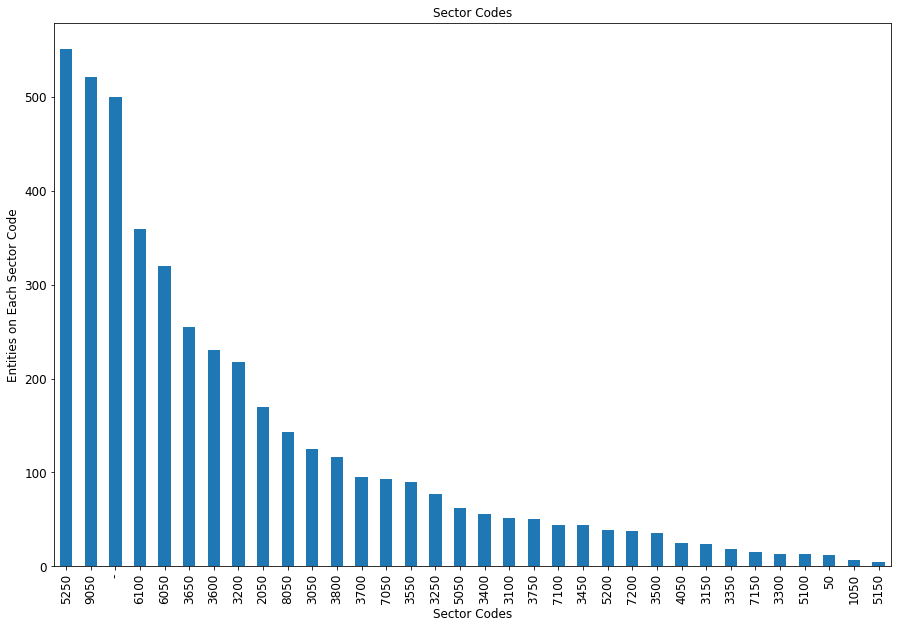

In [ ]:
ax = stock_list_df['33SectorCode'].value_counts().plot(kind='bar', title='Sector Codes', figsize=(15, 10), fontsize=12)
ax.set_xlabel("Sector Codes", fontsize=12) 
ax.set_ylabel("Entities on Each Sector Code", fontsize=12)

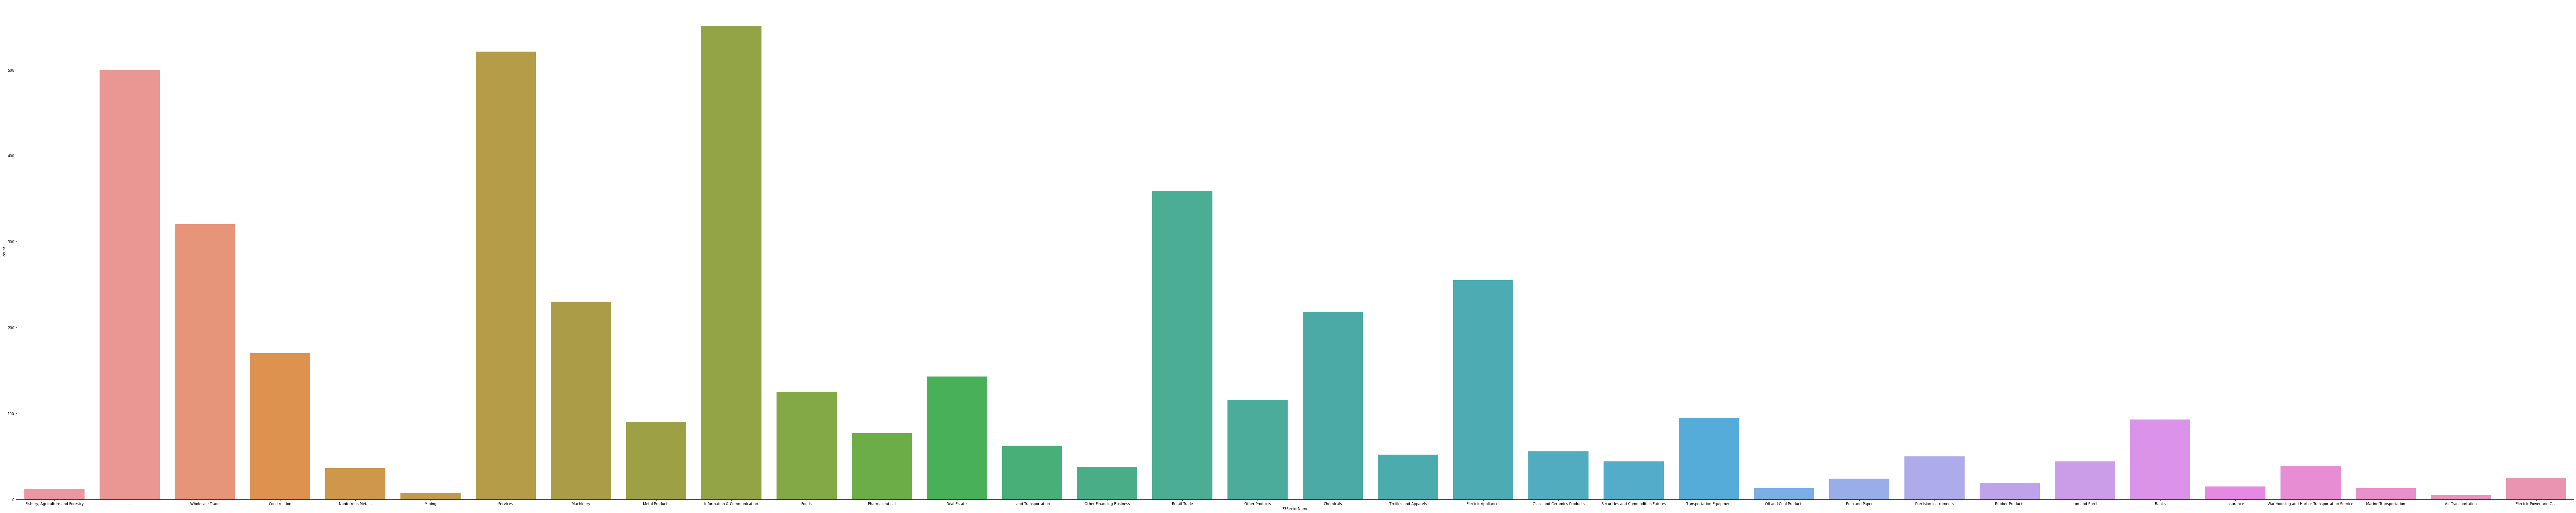

In [ ]:
sns.catplot(x="33SectorName", kind="count", data=stock_list_df, aspect=5, height=20)
plt.savefig("33sectornames.png")

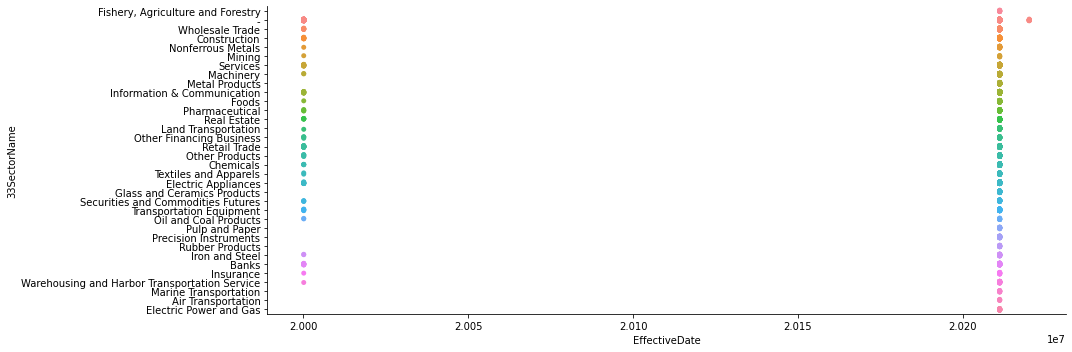

In [ ]:
sns.catplot(x="EffectiveDate", y="33SectorName", data=stock_list_df, aspect=3)

In [ ]:
dist=stock_list_df.groupby('SecuritiesCode').size().reset_index(name='total')
stock_list_df_two=pd.merge(stock_list_df,dist, how='left',on=['SecuritiesCode'])
stock_list_df_two=stock_list_df_two.groupby(['17SectorName']).total.sum().reset_index(name='total')
fig = px.bar(x = stock_list_df_two["17SectorName"],
             y = stock_list_df_two['total'], 
             color = stock_list_df_two["17SectorName"],
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Assets")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Data Distribution ', # Text of title
        'y':0.95, # position of title in y-axis in numbers
        'x':0.5, # position of title in x-axis in numbers
        'xanchor': 'center', # direction of position over title (x)
        'yanchor': 'top'} , # direction of position over title (y)
        template="plotly_white")
fig.show()

**EDA Tahap 2: Dataframes Financials**

In [ ]:
dist_two=financials_df.groupby('SecuritiesCode').size().reset_index(name='total')
financials_df_two=pd.merge(financials_df,dist_two, how='left',on=['SecuritiesCode'])
financials_df_two=financials_df_two.groupby(['TypeOfDocument']).total.sum().reset_index(name='total')
fig = px.bar(x = financials_df_two["TypeOfDocument"],
             y = financials_df_two['total'], 
             color = financials_df_two["TypeOfDocument"],
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Assets")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Data Distribution ', # Text of title
        'y':0.95, # position of title in y-axis in numbers
        'x':0.5, # position of title in x-axis in numbers
        'xanchor': 'center', # direction of position over title (x)
        'yanchor': 'top'} , # direction of position over title (y)
        template="plotly_white")
fig.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

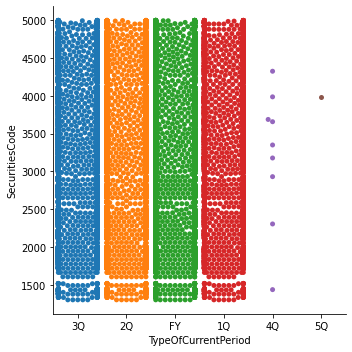

In [ ]:
sns.catplot(x="TypeOfCurrentPeriod", y="SecuritiesCode", kind="swarm", data=financials_df[financials_df.SecuritiesCode.between(100, 5000, inclusive=False)])

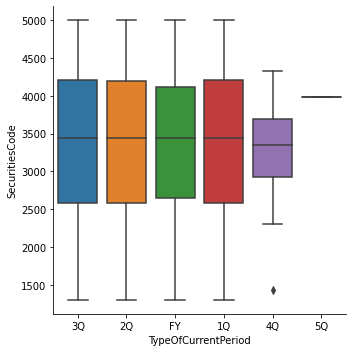

In [ ]:
sns.catplot(x="TypeOfCurrentPeriod", y="SecuritiesCode", kind="box", data=financials_df[financials_df.SecuritiesCode.between(100, 5000, inclusive=False)])

Text(0, 0.5, '# on Each Current Period')

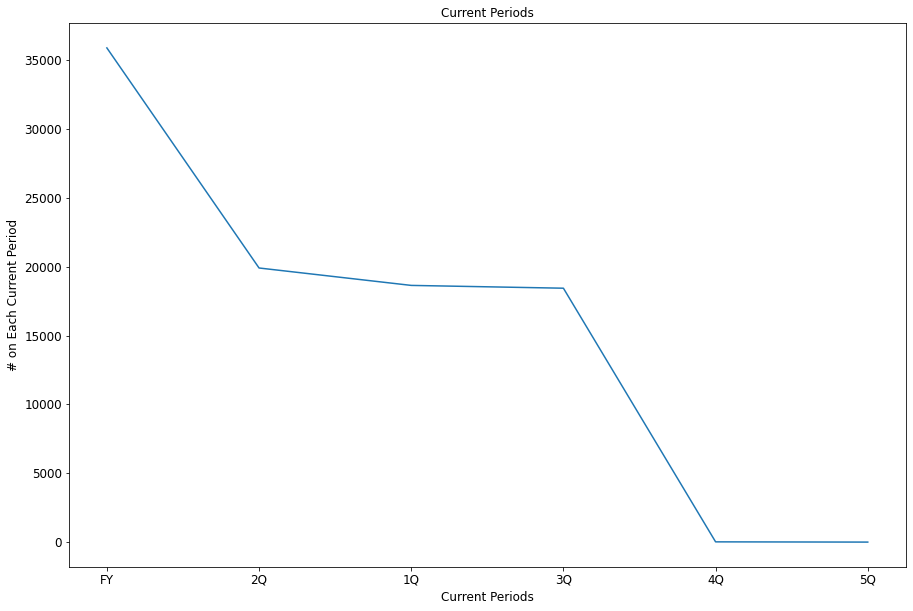

In [ ]:
ax = financials_df['TypeOfCurrentPeriod'].value_counts().plot(kind='line', title='Current Periods', figsize=(15, 10), fontsize=12)
ax.set_xlabel("Current Periods", fontsize=12) 
ax.set_ylabel("# on Each Current Period", fontsize=12)

**EDA Tahap 3: Options**

Text(0, 0.5, '# of Stock')

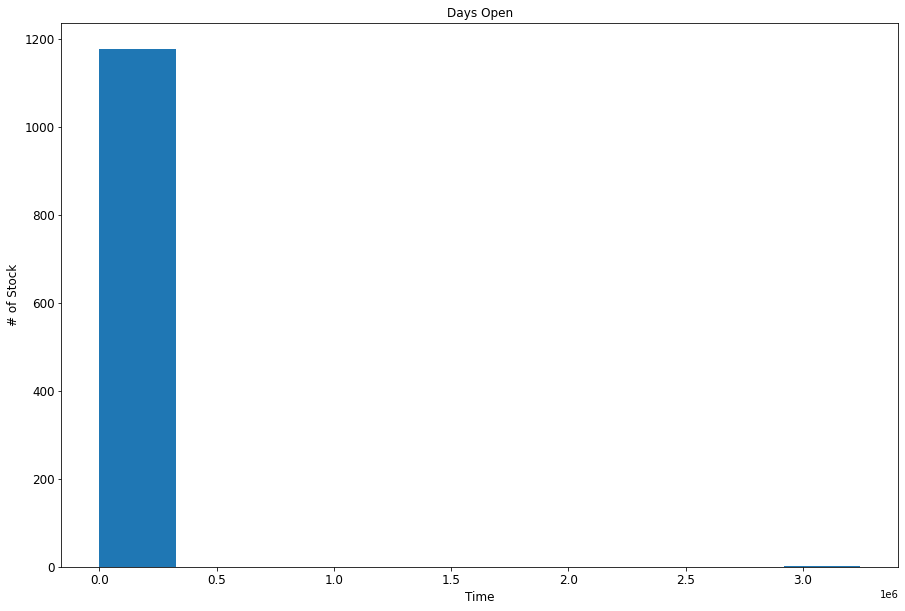

In [ ]:
ax = options_df['WholeDayOpen'].value_counts().plot(kind='hist', title='Days Open', figsize=(15, 10), fontsize=12)
ax.set_xlabel("Time", fontsize=12) 
ax.set_ylabel("# of Stock", fontsize=12)

In [ ]:
from math import pi
from bokeh.plotting import figure
from bokeh.io import output_notebook,show
from bokeh.resources import INLINE

output_notebook(resources=INLINE)
options_df.index = pd.DatetimeIndex(options_df['Date'])

inc = options_df.WholeDayClose > options_df.WholeDayOpen
dec = options_df.WholeDayOpen > options_df.WholeDayClose

w = 12*60*60*1000

p = figure(x_axis_type="datetime", plot_width=800, plot_height=500, title = "Whole Day Stocks")
p.segment(options_df.index, options_df.WholeDayHigh, options_df.index, options_df.WholeDayLow, color="black")
p.vbar(options_df.index[inc], w, options_df.WholeDayOpen[inc], options_df.WholeDayClose[inc], fill_color="lawngreen", line_color="red")
p.vbar(options_df.index[dec], w, options_df.WholeDayOpen[dec], options_df.WholeDayClose[dec], fill_color="tomato", line_color="lime")

show(p)

**EDA Tahap 4: Secondary_Stock_Prices**

In [ ]:
def get_data(stock_id, data=sec_stock_prices_df):
    get_data_df = sec_stock_prices_df[sec_stock_prices_df["SecuritiesCode"] == stock_id].reset_index(drop=True)
    get_data_df["Date"] = pd.to_datetime(get_data_df["Date"])
    get_data_df = get_data_df.set_index("Date")
    return get_data_df

samsung = get_data(stock_id=1313)
nikko = get_data(stock_id=1330)

In [ ]:
def sec_candlestick_chart(data, title):
    import plotly.graph_objects as go
    
    candlestick = go.Figure(data=[go.Candlestick(x=data.index, open=data[("Open")], high=data[("High")], low=data[("Low")], close=data[("Close")])])
    candlestick.update_xaxes(title_text='Time', rangeslider_visible=True)
    
    candlestick.update_layout(
        title={
            'text': '{:} Candlestick Chart (Sec)'.format(title), # text to title our candlestick chart
            'y': 0.9, # y-position
            'x': 0.5, # x-position
            'xanchor': 'center', # position in x-axis
            'yanchor': 'top'}, # position in y-axis
        template="seaborn")
    
    candlestick.update_yaxes(title_text='Price in USD', ticksuffix='$')
    return candlestick

In [ ]:
samsungplot = sec_candlestick_chart(samsung, title="Samsung")
samsungplot.show()

In [ ]:
nikkoplot = sec_candlestick_chart(nikko, title="Nikko Exchange")
nikkoplot.show()

In [ ]:
samsung["Return"] = (samsung["Close"]/samsung["Close"].shift(1)) - 1

In [ ]:
nikko["Return"] = (nikko["Close"]/nikko["Close"].shift(1)) - 1

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
fig = px.histogram(samsung, x = "Return")

fig.update_layout(
    plot_bgcolor = "white",
    title_text="Stock Volatility of Samsung"
)

fig.update_yaxes(showticklabels = True, showline = True, linewidth = 2, linecolor = "black",
                title_text="<b>Value</b>")
fig.update_xaxes(showticklabels = True, showline = True, linewidth = 2, linecolor = "black", 
                 title_text="<b>Return</b>")
iplot(fig)

In [ ]:
fig = px.histogram(nikko, x = "Return")

fig.update_layout(
    plot_bgcolor = "white",
    title_text="Stock Volatility of Nikko Exchange"
)

fig.update_yaxes(showticklabels = True, showline = True, linewidth = 2, linecolor = "black",
                title_text="<b>Value</b>")
fig.update_xaxes(showticklabels = True, showline = True, linewidth = 2, linecolor = "black", 
                 title_text="<b>Return</b>")
iplot(fig)

**EDA Tahap 5: Stocks_prices**

In [ ]:
def get_data_two(stock_id, data=stock_prices_df):
    get_data_df = stock_prices_df[stock_prices_df["SecuritiesCode"] == stock_id].reset_index(drop=True)
    get_data_df["Date"] = pd.to_datetime(get_data_df["Date"])
    get_data_df = get_data_df.set_index("Date")
    return get_data_df

In [ ]:
kyokuyo = get_data_two(stock_id=1301)
maruha = get_data_two(stock_id=1333)

In [ ]:
def candlestick_chart(data, title):
    import plotly.graph_objects as go
    
    candlestick = go.Figure(data=[go.Candlestick(x=data.index, open=data[("Open")], high=data[("High")], low=data[("Low")], close=data[("Close")])])
    candlestick.update_xaxes(title_text='Time', rangeslider_visible=True)
    
    candlestick.update_layout(
        title={
            'text': '{:} Candlestick Chart (Sec)'.format(title), # text to title our candlestick chart
            'y': 0.9, # y-position
            'x': 0.5, # x-position
            'xanchor': 'center', # position in x-axis
            'yanchor': 'top'}, # position in y-axis
        template="seaborn")
    
    candlestick.update_yaxes(title_text='Price in USD', ticksuffix='$')
    return candlestick

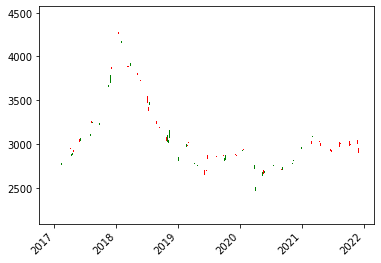

In [ ]:
#create figure
plt.figure()

#define width of candlestick elements
width = .4
width2 = .05

#define up and down prices
up = kyokuyo[kyokuyo.Close>=kyokuyo.Open]
down = kyokuyo[kyokuyo.Close<kyokuyo.Open]

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

#plot down prices
plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

In [ ]:
kyokuyoplot = candlestick_chart(kyokuyo, title="Kyokuyo")
kyokuyoplot.show()

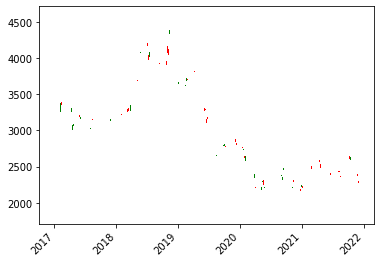

In [ ]:
#create figure
plt.figure()

#define width of candlestick elements
width = .4
width2 = .05

#define up and down prices
up = maruha[maruha.Close>=maruha.Open]
down = maruha[maruha.Close<maruha.Open]

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

#plot down prices
plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

In [ ]:
maruhaplot = candlestick_chart(maruha, title="Maruha")
maruhaplot.show()

In [ ]:
kyokuyo["Return"] = (kyokuyo["Close"]/kyokuyo["Close"].shift(1)) - 1
maruha["Return"] = (maruha["Close"]/maruha["Close"].shift(1)) - 1

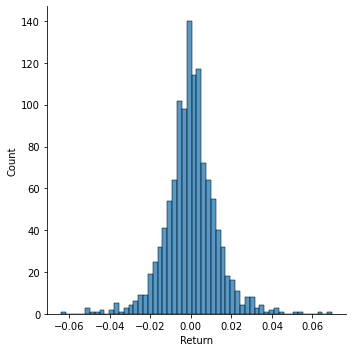

In [ ]:
sns.displot(kyokuyo, x="Return")

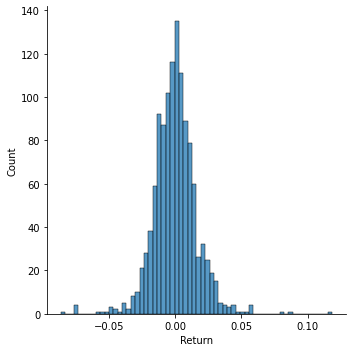

In [ ]:
sns.displot(maruha, x="Return")

**EDA Tahap 6: Trades**

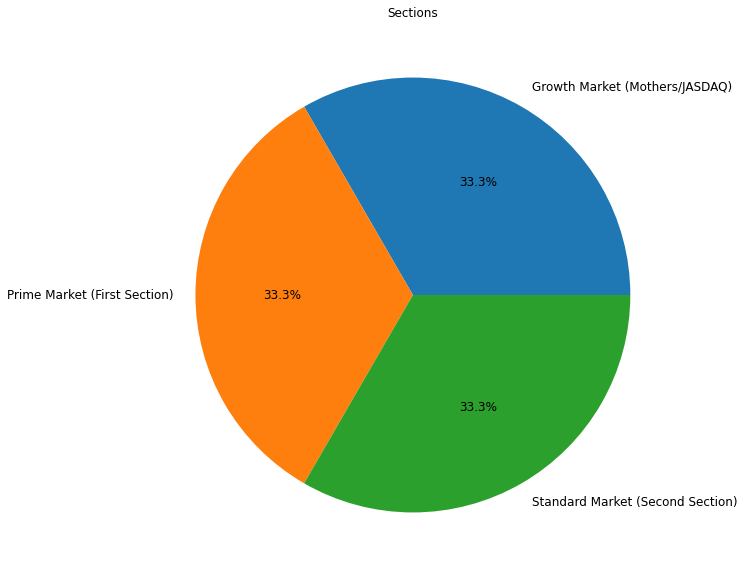

In [ ]:
fig1, ax = plt.subplots()
ax = trades_df["Section"].value_counts().plot(autopct='%1.1f%%', kind='pie', title='Sections', figsize=(15, 10), fontsize=12)
plt.axis('off')
plt.show()

In [ ]:
startdate = trades_df.StartDate.value_counts().to_frame().reset_index().rename(columns = {'index':'StartDate', 'StartDate':'count'})

fig = px.pie(startdate.head(20), values='count', names='StartDate', title='StartDate Counts')
fig.show()